In [1]:
# Referenciando o google drive
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import shutil
shutil.copy("/content/drive/MyDrive/RenatoBanzai_quali/Dados/dataset4.zip", "./")

#2min

'./dataset4.zip'

In [3]:
!unzip -qq "./dataset4.zip"
#1min

In [4]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [5]:
trans = transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [6]:
# Load the Data

# Set train and valid directory paths

dataset = 'dataset4'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'validation')
test_directory = os.path.join(dataset, 'test')



# Batch size
bs = 512

# Number of classes
num_classes = len(os.listdir(valid_directory))  #10#2#257
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=trans),
    'valid': datasets.ImageFolder(root=valid_directory, transform=trans),
    'test': datasets.ImageFolder(root=test_directory, transform=trans)
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True, num_workers=2)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True, num_workers=2)
test_data_loader = DataLoader(data['test'], num_workers=2)

68
{0: 'Abramites hypselonotus', 1: 'Acestrorhynchus pantaneiro', 2: 'Apareiodon affinis', 3: 'Aphyocharax anisitsi', 4: 'Aphyocharax paraguayensis', 5: 'Aphyocharax rathbuni', 6: 'Apistogramma borellii', 7: 'Apistogramma trifasciata', 8: 'Apteronotus albifrons', 9: 'Astronotus crassipinnis', 10: 'Brochis britskii', 11: 'Brochis splendens', 12: 'Brycon hilarii', 13: 'Bujurquina vittata', 14: 'Callichthys callichthys', 15: 'Catathyridium jenynsii', 16: 'Catoprion mento', 17: 'Cichlasoma dimerus', 18: 'Corydoras aeneus', 19: 'Corydoras hastatus', 20: 'Crenicichla lepidota', 21: 'Eigenmannia virescens', 22: 'Gasteropelecus sternicla', 23: 'Gymnocorymbus ternetzi', 24: 'Gymnogeophagus balzanii', 25: 'Gymnotus inaequilabiatus', 26: 'Hemigrammus ulreyi', 27: 'Hoplias malabaricus', 28: 'Hoplosternum littorale', 29: 'Hyphessobrycon anisitsi', 30: 'Hyphessobrycon elachys', 31: 'Hyphessobrycon eques', 32: 'Hyphessobrycon herbertaxelrodi', 33: 'Laetacara dorsigera', 34: 'Lepidosiren paradoxa', 35

In [7]:
train_data_size, valid_data_size, test_data_size

(46400, 3871, 3900)

In [8]:
alexnet = models.alexnet(pretrained=True)
alexnet

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 227MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
# Freeze model parameters
for param in alexnet.parameters():
    param.requires_grad = False

In [10]:
# Change the final layer of AlexNet Model for Transfer Learning
alexnet.classifier[6] = nn.Linear(4096, num_classes)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
alexnet.cuda()
summary(alexnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [12]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [13]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))


        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

        if avg_valid_acc > 0.81:
          return model, history

        # Save if the model has best accuracy till now
        #torch.save(model, '/content/drive/MyDrive/RenatoBanzai_quali/Dados/model_'+str(epoch)+'.pt')

    return model, history

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 10
trained_model, history = train_and_validate(alexnet, loss_func, optimizer, num_epochs)


#l4gpu 142s/epoch

Epoch: 1/10
Epoch : 001, Training: Loss: 1.7093, Accuracy: 54.8685%, 
		Validation : Loss : 1.3267, Accuracy: 65.1770%, Time: 86.5970s
Epoch: 2/10
Epoch : 002, Training: Loss: 0.9701, Accuracy: 72.5948%, 
		Validation : Loss : 1.2191, Accuracy: 67.8119%, Time: 90.1230s
Epoch: 3/10
Epoch : 003, Training: Loss: 0.7629, Accuracy: 78.0474%, 
		Validation : Loss : 1.1966, Accuracy: 68.5353%, Time: 86.8046s
Epoch: 4/10
Epoch : 004, Training: Loss: 0.6421, Accuracy: 81.5323%, 
		Validation : Loss : 1.1768, Accuracy: 69.2069%, Time: 88.2303s
Epoch: 5/10
Epoch : 005, Training: Loss: 0.5628, Accuracy: 83.6681%, 
		Validation : Loss : 1.1887, Accuracy: 69.0261%, Time: 86.3268s
Epoch: 6/10
Epoch : 006, Training: Loss: 0.5081, Accuracy: 85.2845%, 
		Validation : Loss : 1.1922, Accuracy: 69.4136%, Time: 85.4053s
Epoch: 7/10
Epoch : 007, Training: Loss: 0.4636, Accuracy: 86.3427%, 
		Validation : Loss : 1.2008, Accuracy: 69.1036%, Time: 85.6165s
Epoch: 8/10
Epoch : 008, Training: Loss: 0.4326, Accura

In [15]:
torch.save(history, '/content/drive/MyDrive/RenatoBanzai_quali/Codigo/'+'history_alex_dataset4.pt')
torch.save(trained_model, '/content/drive/MyDrive/RenatoBanzai_quali/Codigo/'+'model_alex_dataset4.pt')

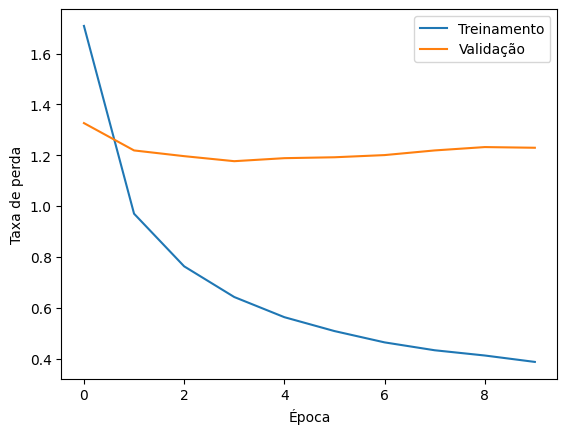

In [16]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Treinamento', 'Validação'])
plt.xlabel('Época')
plt.ylabel('Taxa de perda')
# plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

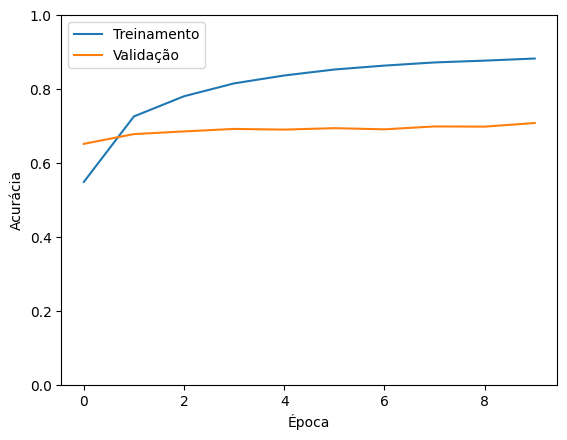

In [17]:
plt.plot(history[:,2:4])
plt.legend(['Treinamento', 'Validação'])
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [18]:
import cv2

def predict(model, test_image_name, new=False):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    model.cuda()
    transform = trans
    if new==False:
      test_image = Image.open(test_image_name)
    else:
      test_image = cv2.imread(test_image_name)
      test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB )
      test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB )
      test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB )
      test_image = Image.fromarray(test_image)

    plt.imshow(test_image)
    test_image_tensor = transform(test_image)
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)

    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(3, dim=1)

        for i in range(3):
            print("Predcition", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])

Predcition 1 : Salminus brasiliensis , Score:  0.99986786
Predcition 2 : Apistogramma borellii , Score:  0.00012230972
Predcition 3 : Brycon hilarii , Score:  7.0032656e-06


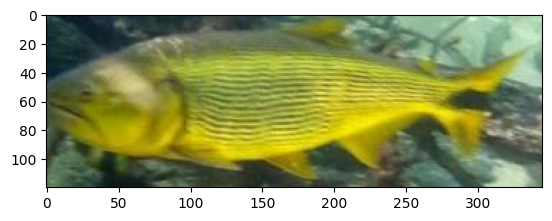

In [19]:
predict(trained_model, "/content/dataset4/test/Salminus brasiliensis/20_09320.jpg")

Predcition 1 : Abramites hypselonotus , Score:  0.88399315
Predcition 2 : Otocinclus vittatus , Score:  0.033306234
Predcition 3 : Corydoras hastatus , Score:  0.019343967


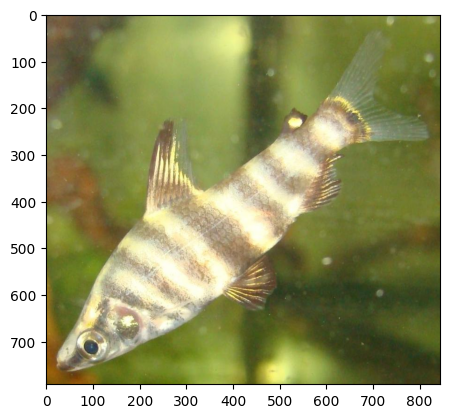

In [20]:
predict(trained_model, "/content/dataset4/test/Abramites hypselonotus/01_00219.jpg")

Predcition 1 : Abramites hypselonotus , Score:  0.99940133
Predcition 2 : Platydoras armatulus , Score:  0.0002736512
Predcition 3 : Leporinus striatus , Score:  0.0002042139


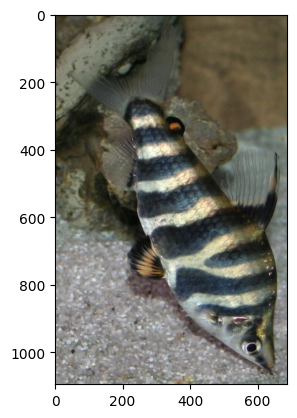

In [21]:
predict(trained_model,"/content/dataset4/test/Abramites hypselonotus/01_00224.jpg")

Predcition 1 : Acestrorhynchus pantaneiro , Score:  0.42367902
Predcition 2 : Rivulus punctatus , Score:  0.33480763
Predcition 3 : Aphyocharax rathbuni , Score:  0.075429216


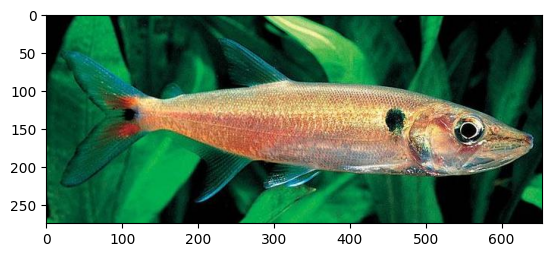

In [22]:
predict(trained_model,"/content/dataset4/test/Acestrorhynchus pantaneiro/04_00725.jpg")

Predcition 1 : Sorubim lima , Score:  0.62862086
Predcition 2 : Brycon hilarii , Score:  0.23255436
Predcition 3 : Pseudotylosurus angusticeps , Score:  0.07222355


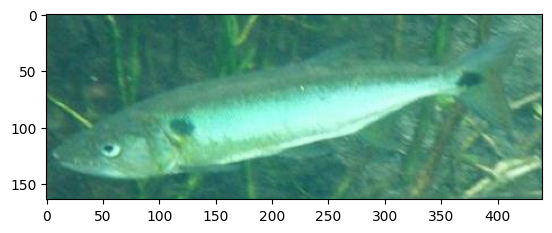

In [23]:
predict(trained_model,"/content/dataset4/test/Acestrorhynchus pantaneiro/04_00736.jpg")

Predcition 1 : Hemigrammus ulreyi , Score:  0.8698752
Predcition 2 : Rhaphiodon vulpinus , Score:  0.05393776
Predcition 3 : Apareiodon affinis , Score:  0.049788907


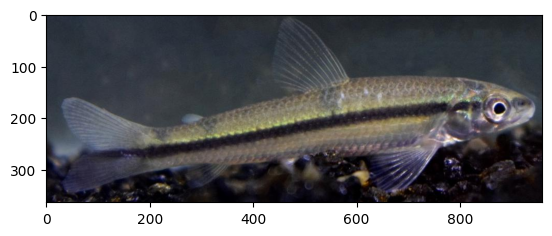

In [24]:
predict(trained_model,"/content/dataset4/test/Apareiodon affinis/52_20487.jpg")

Predcition 1 : Otocinclus vittatus , Score:  0.6399476
Predcition 2 : Eigenmannia virescens , Score:  0.23473395
Predcition 3 : Apareiodon affinis , Score:  0.112961106


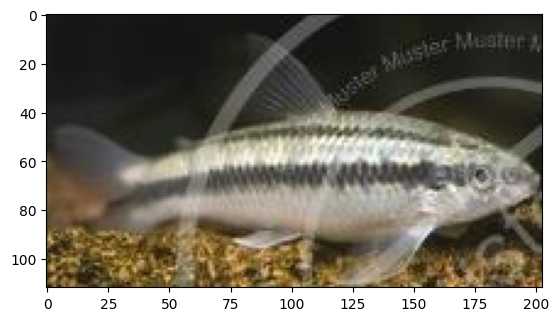

In [25]:
predict(trained_model,"/content/dataset4/test/Apareiodon affinis/52_20493.jpg")

Predcition 1 : Aphyocharax anisitsi , Score:  0.63770336
Predcition 2 : Aphyocharax rathbuni , Score:  0.35241932
Predcition 3 : Hyphessobrycon anisitsi , Score:  0.0073694633


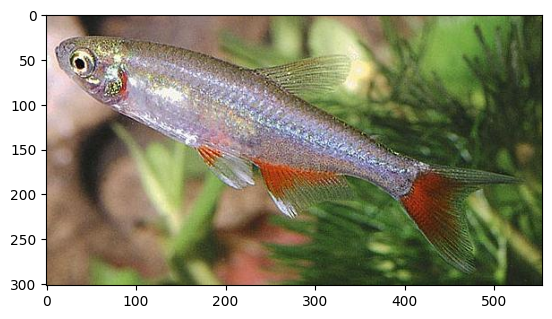

In [26]:
predict(trained_model,"/content/dataset4/test/Aphyocharax anisitsi/05_00873.jpg")

In [27]:
test_loss = 0
test_acc = 0
all_labels = []
all_predictions = []

# Validation - No gradient tracking needed
with torch.no_grad():

    # Set to evaluation mode
    trained_model.eval()

    # Validation loop
    for j, (inputs, labels) in enumerate(test_data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        all_labels.append(labels.item())

        # Forward pass - compute outputs on input data using the model
        outputs = trained_model(inputs)

        # Compute loss
        loss = loss_func(outputs, labels)

        # Compute the total loss for the batch and add it to valid_loss
        test_loss += loss.item() * inputs.size(0)

        # Calculate validation accuracy
        ret, predictions = torch.max(outputs.data, 1)
        all_predictions.append(predictions.item())
        correct_counts = predictions.eq(labels.data.view_as(predictions))

        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))

        # Compute total accuracy in the whole batch and add to valid_acc
        test_acc += acc.item() * inputs.size(0)

        #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

test_acc/test_data_size

0.7112820512820512

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# or:
# from tensorflow.math import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt


cm = confusion_matrix(all_labels, all_predictions)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
np.mean(precision)

np.float64(0.6924229530230781)

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score
print("precision_score", precision_score(all_labels, all_predictions, average='weighted'))
print("recall_score", recall_score(all_labels, all_predictions, average='weighted'))
print("f1_score", f1_score(all_labels, all_predictions, average='weighted'))

precision_score 0.7156488425668838
recall_score 0.7112820512820512
f1_score 0.7061269932360236


In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# or:
# from tensorflow.math import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt


cm = confusion_matrix(all_labels, all_predictions)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
precision

array([0.86111111, 0.65384615, 0.57142857, 0.69827586, 0.82142857,
       0.63043478, 0.8       , 0.81818182, 0.71428571, 0.8       ,
       0.53846154, 0.53125   , 0.82735426, 0.69444444, 0.5       ,
       0.78571429, 0.8       , 0.55172414, 0.5060241 , 0.72077922,
       0.73333333, 0.8       , 0.82352941, 0.69158879, 0.57575758,
       0.75      , 0.62857143, 0.5942029 , 0.57142857, 0.64912281,
       0.78125   , 0.82248521, 0.78974359, 0.6       , 0.66666667,
       0.61111111, 0.66666667, 0.75      , 0.65243902, 0.64705882,
       0.57142857, 0.79347826, 0.68421053, 0.58139535, 0.64705882,
       0.73333333, 0.83333333, 0.50847458, 0.47826087, 0.83333333,
       0.83333333, 0.76315789, 0.86666667, 0.6       , 0.6       ,
       0.90322581, 0.56      , 0.75347222, 0.63636364, 0.59090909,
       0.875     , 0.86666667, 0.58181818, 0.52631579, 0.59090909,
       0.68421053, 0.78947368, 0.76923077])

In [31]:
top_k_indices = np.argpartition(precision, -10)[-10:]
for x in top_k_indices:
  print(idx_to_class[x], precision[x])

Gasteropelecus sternicla 0.8235294117647058
Brycon hilarii 0.827354260089686
Platydoras armatulus 0.8333333333333334
Pimelodus ornatus 0.8333333333333334
Potamotrygon motoro 0.8333333333333334
Abramites hypselonotus 0.8611111111111112
Pseudohemiodon platycephalus 0.8666666666666667
Schizodon isognathus 0.8666666666666667
Salminus brasiliensis 0.875
Pseudotylosurus angusticeps 0.9032258064516129


In [32]:
bot_k_indices = np.argpartition(precision, 10)[:10]
for x in bot_k_indices:
  print(idx_to_class[x], precision[x])

Pinirampus pirinampu 0.4782608695652174
Callichthys callichthys 0.5
Corydoras aeneus 0.5060240963855421
Pincachara 0.5084745762711864
Sorubim lima 0.5263157894736842
Brochis splendens 0.53125
Brochis britskii 0.5384615384615384
Cichlasoma dimerus 0.5517241379310345
Pterodoras granulosus 0.56
Hoplosternum littorale 0.5714285714285714
